In [2]:
import os
import copy
import gc
import glob
import sys
import random
import string
import tqdm
import json
import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

from rdkit import Chem

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import codecs
from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.pretokenizer import kmer_tokenizer
from SmilesPE.learner import *
from SmilesPE.tokenizer import *

import matplotlib.pyplot as plt

supp_script_path = '../../supp_scripts/'
sys.path.append(supp_script_path) # path for support scripts folder
import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

Could not import custom script CNN


(device(type='cuda'), True)

In [6]:
# To remove warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [7]:
parameter_filename = "parameters_seq2seq.json" 

In [9]:
# Whole section is to read parameters from the parameter file
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file_train = parameters["input_file_train"] # input file
input_file_test = parameters["input_file_test"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

if not trial:
    run_folder = parameters["run_folder"]

gpu_id = int(parameters["gpu_id"])
if gpu_id != None:
    device = "cuda:" + str(gpu_id)
else:
    gpu_id = 0
    
# Removing data with lower distribution
enable_label_cutoff = parameters["label_cutoff"]["enable_label_cutoff"]
lower_label_count_cutoff = int(parameters["label_cutoff"]["lower_label_count_cutoff"])
upper_label_count_cutoff = int(parameters["label_cutoff"]["upper_label_count_cutoff"])

# Sequence length to be considered
lower_cutoff = int(parameters["sequence_length_cutoff"]["lower_cutoff"])
upper_cutoff = int(parameters["sequence_length_cutoff"]["upper_cutoff"])

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

label_wise_augmentation = parameters["augmentation"]["label_wise_augmentation"]
number_of_augmentation = int(parameters["augmentation"]["number_of_augmentation"])
iteration = int(parameters["augmentation"]["iteration"])

tokenization = parameters["tokens"]["tokenization"] # options are SPE,atomwise,vocab_file
if tokenization == "SPE":
    spe_min_frequency = int(parameters["tokens"]["spe_min_frequency"])
sos_eos_tokens = parameters["tokens"]["sos_eos_tokens"]

use_vocab_file = parameters["vocab_file"]["use_vocab_file"]
if use_vocab_file:
    vocab_file_path = parameters["vocab_file"]["vocab_file_path"]

#####################
# Network parameters#
#####################
load_model = parameters["pretrained_model"]["load_model"]
#if load_model is True set the path for pretrained_model_path
pretrained_model_path = parameters["pretrained_model"]["pretrained_model_path"]

hidden_size = int(parameters["lstm_parameters"]["hidden_size"])
num_layers = int(parameters["lstm_parameters"]["num_layers"])
en_embedding_size = int(parameters["lstm_parameters"]["en_embedding_size"])
en_dropout = float(parameters["lstm_parameters"]["en_dropout"])

fc_size = int(parameters["fc_layer_parameters"]["fc_size"])
fc_dropout = float(parameters["fc_layer_parameters"]["fc_dropout"]) # fully connected layer dropout

epochs = int(parameters["network_parameters"]["epochs"])
batch_size = int(parameters["network_parameters"]["batch_size"])
learning_rate = float(parameters["network_parameters"]["learning_rate"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

Number_of_workers = int(parameters["Number_of_workers"])

##################
### Do not edit###
##################
if not trial:
    os.system("mkdir " + str(run_folder))

atomwise_tokenization = False
train_SPE = False

if tokenization == "SPE":
    train_SPE = True
elif tokenization == "atomwise":
    atomwise_tokenization = True
else:
    atomwise_tokenization = True
    print ("Tokenization not provided/incorrect. Using atomwise tokenization")

if not trial:
    network_parameter_output = open(str(run_folder) + "/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

In [10]:
# seq2seq network, only with the perceiver connected to the fully connected layer for classification
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size) #,padding_idx=0)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p,batch_first=False)

    def forward(self, x):
        # x shape: (N,seq_length) where N is batch size
          
        pack_pad_list = x.shape[0] - (np.array(x.cpu()) == 0).sum(0)
        
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (N,seq_length, embedding_size)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedding, 
                                                                lengths = torch.as_tensor(pack_pad_list, dtype=torch.int64).cpu(),
                                                                batch_first = False,
                                                                enforce_sorted=False
                                                               )
        
        outputs, (hidden, cell) = self.rnn(packed_embedded)
        
        return hidden[hidden.shape[0]-1]
        
class FC_layer(nn.Module):
    def __init__(self, hidden_size, output_size,p):
        super(FC_layer, self).__init__()
        
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        
        self.fc1 = nn.Linear(hidden_size, fc_size)   
        self.fc2 = nn.Linear(fc_size, output_size)

    def forward(self, hidden):
        fc_out = self.dropout(self.lrelu((self.fc1(hidden))))
        fc_out = self.fc2(fc_out)
        
        return fc_out

class seq2seq(nn.Module):
    def __init__(self, encoder, fc_layer):
        super(seq2seq, self).__init__()
        self.encoder = encoder
        self.fc_layer = fc_layer
        self.softmax = nn.Softmax()
        
    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]

        hidden = self.encoder(source)
        outputs = self.fc_layer(hidden)        
        #outputs = self.softmax(outputs)
        
        return outputs    

In [11]:
# Reading train_valid and test splits from the file and make it to a dataframe
smiles_label_test = {line.split()[0]:line.split()[1] for line in open(input_file_test,"r").readlines()}
smiles_label_test = dict(sorted(smiles_label_test.items(), key=lambda item: item[1]))

smiles_label_train = {line.split()[0]:line.split()[1] for line in open(input_file_train,"r").readlines()}
smiles_label_train = dict(sorted(smiles_label_train.items(), key=lambda item: item[1]))

train_valid_df = su.dict_to_label(smiles_label_train)
train_valid_df = train_valid_df
test_df = su.dict_to_label(smiles_label_test)
test_df = test_df.sample(frac=1).reset_index(drop=True)

def plot_loss_accuracy(train_list,valid_list,filename):
    plt.clf()
    plt.cla()
    plt.close()
    plt.plot(train_list, label='Training')
    plt.plot(valid_list, label='Validation')
    plt.legend()
    plt.savefig(filename)
    plt.clf()
    plt.cla()
    plt.close()
    
gc.collect()
torch.cuda.empty_cache()

Best model on loss and accuracy
LOSS train: 0.051777192113351904  val: 0.2041056089103222 	ACCU train: 0.97265625  val: 0.953125
LOSS train: 0.018968748116296612  val: 0.21160579919815065 	ACCU train: 0.9904513888888888  val: 0.959375
Final model
LOSS train: 0.001352951567645909  val: 0.37693544626235964 	ACCU train: 1.0  val: 0.946875


KeyboardInterrupt: 

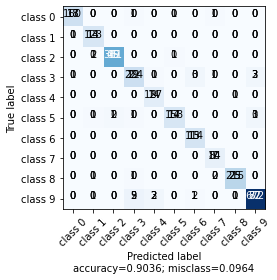

In [12]:
for fold in range(k_fold_value):
    
    if not trial:
        log_file = open(str(run_folder) + "/model_" + str(fold) + ".txt","w")
        model_output_name = str(run_folder) + "/model_" + str(fold) + ".pth"
    
    piece_count = fold + 1
    # create train and valid dataframe for the current fold
    train,valid,piece_count = su.CV.get_K_fold_cv_data(train_valid_df,k_fold_value,piece_count,shuffle_output=True)
    train_df = pd.DataFrame(train.items(),columns=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True)
    valid_df = pd.DataFrame(valid.items(),columns=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True)
    
    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train_df)).cuda(gpu_id)
        if not trial:
            log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
            
    if not trial:
        log_file.write("Class distribution before augmentation\n")
        log_file.write("Train data\n")
        log_file.write(str(train_df.groupby('Label').count()) + "\n")
        log_file.write("Valid data\n")
        log_file.write(str(valid_df.groupby('Label').count()) + "\n")
        log_file.write("Test data\n")
        log_file.write(str(test_df.groupby('Label').count()) + "\n")
    
    
    # Data augmentation
    if number_of_augmentation > 0:
        if label_wise_augmentation:
            # label wise augmentation list calculation
            train_augmentation_list = su.get_augmentation_list(train_df,number_of_augmentation)
            number_of_augmentation_train = train_augmentation_list
            
            valid_augmentation_list = su.get_augmentation_list(valid_df,number_of_augmentation)
            number_of_augmentation_valid = valid_augmentation_list
            
            #if fold == 0:
            test_augmentation_list = su.get_augmentation_list(test_df,number_of_augmentation)
            number_of_augmentation_test = test_augmentation_list

        else:   
            number_of_augmentation_train = number_of_augmentation
            number_of_augmentation_valid = number_of_augmentation
            #if fold == 0:
            number_of_augmentation_test = number_of_augmentation
                
        train_data = su.smiles_augmentation(train_df,
                                            N_rounds=number_of_augmentation_train,
                                            iteration=iteration,
                                            data_set_type="train_data",
                                            Number_of_workers=Number_of_workers)     
            
        valid_data = su.smiles_augmentation(valid_df,
                                            N_rounds=number_of_augmentation_valid,
                                            iteration=iteration,
                                            data_set_type="valid_data",
                                            Number_of_workers=Number_of_workers)
        #if fold == 0:
        test_data = su.smiles_augmentation(test_df,
                                            N_rounds=number_of_augmentation_test,
                                            iteration=iteration,
                                            data_set_type="test_data",
                                            Number_of_workers=Number_of_workers)
        
        if not trial:
            log_file.write("number of augmentation = " + str(number_of_augmentation) + "\n")
            log_file.write("Class distribution after augmentation\n")
            log_file.write("Train data\n")
            log_file.write(str(train_data.groupby('Label').count()) + "\n")
            log_file.write("Valid data\n")
            log_file.write(str(valid_data.groupby('Label').count()) + "\n")
            log_file.write("Test data\n")
            log_file.write(str(valid_data.groupby('Label').count()) + "\n")
    else:
        train_data = train_df
        valid_data = valid_df
        #if fold == 0:
        test_data = test_df
    
    
    # train spe tokenization
    if train_SPE:
        all_smiles = train_data['Smiles'].to_list()
        token_path = str(run_folder) + "/tokens_" + str(fold) + ".txt"
        su.seq2seq.train_spe_tokenizer(all_smiles,token_path,min_frequency=spe_min_frequency,augmentation=0)
    
    
    # create or use vocab
    if use_vocab_file:
        word_index,index_word = su.seq2seq.read_vocab_file(vocab_file_path)
        token_path = ""
    else:
        output_vocab_path = str(run_folder) + "/vocab" + str(fold) + ".txt"
        if train_SPE:
            word_index,index_word = su.seq2seq.create_vocab_file_spe(train_data,
                                                                     token_path,
                                                                     Number_of_workers,
                                                                     output_vocab_path,
                                                                     sos_eos_tokens)
        else:
            token_path = ""
            word_index,index_word = su.seq2seq.create_vocab_file_atomwise(train_data,
                                                                          Number_of_workers,
                                                                          output_vocab_path,
                                                                          sos_eos_tokens)
    
    
    # convert to tokens
    x_train,y_train= su.seq2seq.convert_smiles_to_tokens(train_data,
                                                         lower_cutoff=lower_cutoff,
                                                         upper_cutoff=upper_cutoff,
                                                         Number_of_workers=Number_of_workers,
                                                         token_path=token_path,
                                                         sos_eos_tokens=sos_eos_tokens,
                                                         tokenization=tokenization)
    
    x_valid,y_valid= su.seq2seq.convert_smiles_to_tokens(valid_data,
                                                       lower_cutoff=lower_cutoff,
                                                       upper_cutoff=upper_cutoff,
                                                       Number_of_workers=Number_of_workers,
                                                       token_path=token_path,
                                                       sos_eos_tokens=sos_eos_tokens,
                                                       tokenization=tokenization)
    
    #if fold == 0:
    x_test,y_test= su.seq2seq.convert_smiles_to_tokens(test_data,
                                                       lower_cutoff=lower_cutoff,
                                                       upper_cutoff=upper_cutoff,
                                                       Number_of_workers=Number_of_workers,
                                                       token_path=token_path,
                                                       sos_eos_tokens=sos_eos_tokens,
                                                       tokenization=tokenization)
    
    if not trial:
        log_file.write("Training : Data point = " + str(len(train_df)) + "\n")
        log_file.write("Training : Data point within cutoff criteria = " + str(len(x_train)) + "\n")
        log_file.write("Valid : Data point = " + str(len(valid_df)) + "\n")
        log_file.write("Valid : Data point within cutoff criteria = " + str(len(x_valid)) + "\n")
        log_file.write("Test : Data point = " + str(len(test_df)) + "\n")
        log_file.write("Test : Data point within cutoff criteria = " + str(len(x_test)) + "\n")
    
    
    # convert to index
    x_train_indexed = su.seq2seq.convert_token_to_index_multi(x_train,word_index)
    x_valid_indexed = su.seq2seq.convert_token_to_index_multi(x_valid,word_index)
    #if fold == 0:
    x_test_indexed = su.seq2seq.convert_token_to_index_multi(x_test,word_index)
    
    # create iterator
    train_iterator =  su.seq2seq.make_bucket_iterator(x_train_indexed,y_train,batch_size,device)
    valid_iterator =  su.seq2seq.make_bucket_iterator(x_valid_indexed,y_valid,batch_size,device)
    #if fold == 0:
    test_iterator =  su.seq2seq.make_bucket_iterator(x_test_indexed,y_test,batch_size,device)
        
    # Build model
    input_size_encoder = len(word_index)
    output_size = len(set(y_train))

    encoder_net = Encoder(
        input_size_encoder, 
        en_embedding_size, 
        hidden_size, 
        num_layers, 
        en_dropout).to(device)


    fc_layer = FC_layer(hidden_size, output_size,fc_dropout).to(device)
    
    model = seq2seq(encoder_net, fc_layer).to(device)
    
    if load_model: # Rework has to be done for this
        model.load_state_dict(torch.load(pretrained_model_path), strict=False)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    
    # Training the network
    # List to store values
    train_loss_list = []
    train_accu_list = []
    val_loss_list = []
    val_accu_list = []
    gc.collect()
    torch.cuda.empty_cache()
    
    train_f1_list = []
    valid_f1_list = []
    
    # model training
    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.seq2seq.train(model,criterion,optimizer,train_iterator,device)
        val_loss,val_accu = su.seq2seq.validate(model,criterion,valid_iterator,device)
        
        
        # For callback
        # Callback saves the best model based on the below priority
        # validation loss --> validation accuracy--> training loss--> training accuracy
        if epoch == 0:
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1

        if epoch != 0:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                model_copy = copy.deepcopy(model)
                saved_model_id = epoch + 1

        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
        
    torch.save(model_copy.state_dict(), model_output_name)
    
    plot_loss_accuracy(train_accu_list,val_accu_list,str(run_folder) + "/accuracy_" + str(fold) + ".png")
    plot_loss_accuracy(train_loss_list,val_loss_list,str(run_folder) + "/loss_" + str(fold) + ".png")
    
    log_file.write("\nChosen model = epoch number " + str(saved_model_id))
    
    
    # Re-initializing the model for getting statistics for all the three sets of data for the current fold
    model = seq2seq(encoder_net, fc_layer).to(device)
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)
    
    if not trial:# classification report and confusion matrix plot
        loss,accuracy,prediction_list = su.seq2seq.test(model,criterion,train_iterator,device)
        image_name = str(run_folder) + "/train_" + str(fold) + "_cm.png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.seq2seq.test(model,criterion,valid_iterator,device)
        image_name = str(run_folder) + "/valid_" + str(fold) + "_cm.png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.seq2seq.test(model,criterion,test_iterator,device)
        image_name = str(run_folder) + "/test_" + str(fold) + "_cm.png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
        
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
    
    # best validation loss
    index1 = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    index2 = val_accu_list.index(sorted(val_accu_list)[-1]) # index of highest accuracy
    print ("Best model on loss and accuracy")
    print ("LOSS train:",train_loss_list[index1]," val:",val_loss_list[index1], "\tACCU train:",train_accu_list[index1]," val:",val_accu_list[index1])
    print ("LOSS train:",train_loss_list[index2]," val:",val_loss_list[index2], "\tACCU train:",train_accu_list[index2]," val:",val_accu_list[index2])
    print ("Final model")
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)
    gc.collect()
    torch.cuda.empty_cache()
    